In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Energy/Daily_electricity_consumption.csv')
df.head()

,date_time,active_power_consumed,meter_reading
0,01-01-2009,0.976869,1.946528
1,02-01-2009,1.616326,8.222917
2,03-01-2009,1.328817,7.249306
3,04-01-2009,1.347218,2.253472
4,05-01-2009,1.113889,6.006944


In [6]:
df.tail()

,date_time,active_power_consumed,meter_reading
690,22-11-2010,1.417733,7.038889
691,23-11-2010,1.095511,5.285417
692,24-11-2010,1.247394,8.488889
693,25-11-2010,0.993864,3.522222
694,26-11-2010,1.178230,7.908947


In [7]:
df.shape

(695, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 695 entries, 0 to 694
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_time              695 non-null    object 
 1   active_power_consumed  695 non-null    float64
 2   meter_reading          695 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.4+ KB


In [9]:
df.isnull().sum()

date_time                0
active_power_consumed    0
meter_reading            0
dtype: int64

In [10]:
time = pd.date_range(start='1/1/2009',end='11/26/2010',freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop('date_time',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [11]:
len(time)

695

In [12]:
df.head()

,active_power_consumed,meter_reading
time_stamp,,
2009-01-01,0.976869,1.946528
2009-01-02,1.616326,8.222917
2009-01-03,1.328817,7.249306
2009-01-04,1.347218,2.253472
2009-01-05,1.113889,6.006944


In [13]:
df.tail()

,active_power_consumed,meter_reading
time_stamp,,
2010-11-22,1.417733,7.038889
2010-11-23,1.095511,5.285417
2010-11-24,1.247394,8.488889
2010-11-25,0.993864,3.522222
2010-11-26,1.178230,7.908947


In [14]:
df = df[['active_power_consumed']]

In [15]:
df

,active_power_consumed
time_stamp,
2009-01-01,0.976869
2009-01-02,1.616326
2009-01-03,1.328817
2009-01-04,1.347218
2009-01-05,1.113889
...,...
2010-11-22,1.417733
2010-11-23,1.095511
2010-11-24,1.247394


In [16]:
plt.rcParams['figure.figsize'] = [15,8]

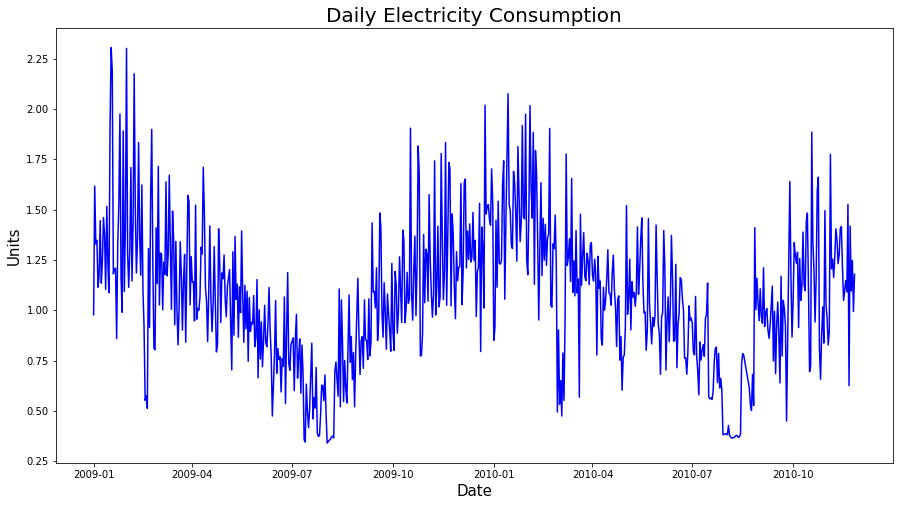

In [17]:
plt.plot(df,color='blue')
plt.title('Daily Electricity Consumption',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [18]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [20]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['active_power_consumed'] = df['active_power_consumed'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1)) #LTSM requires more input features compared to RNN or DNN
scaler = MinMaxScaler(feature_range=(0.1, 1))#LTSM is senstive to the scale of features
df_arr = scaler.fit_transform(df_arr)

In [21]:
train_size = 625
train, test = df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
look_back = 10
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [22]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(615, 1, 10)
(615,)
(60, 1, 10)
(60,)


In [23]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.2 MB/s 


In [24]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [40]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('first_lstm_layer',min_value=8,max_value=128,step=8), activation="relu",return_sequences=True, input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.4)))
    model.add(LSTM(hp.Int('final_lstm_layer',min_value=8,max_value=128,step=8),activation="relu",recurrent_dropout = hp.Choice("last_recurrent_dropout",[0.2,0.4,0.6],default=0.4) ))
    model.add(Dense(hp.Int('dense_layer_1',min_value=8,max_value=128,step=8),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [42]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=20,
    executions_per_trial=2,
    directory='project',
    project_name='elec_consum_2')

In [43]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
first_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
final_lstm_layer (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
last_recurrent_dropout (Choice)
{'default': 0.4, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 128, 'step': 8, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [44]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=33,
             validation_data=(testX, testY))

Trial 20 Complete [00h 01m 24s]
val_mape: 22.294156074523926

Best val_mape So Far: 21.323491096496582
Total elapsed time: 00h 29m 30s
INFO:tensorflow:Oracle triggered exit


In [45]:
tuner.results_summary()

Results summary
Results in project/elec_consum_2
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
first_lstm_layer: 104
first_recurrent_dropout: 0.2
final_lstm_layer: 64
last_recurrent_dropout: 0.6
dense_layer_1: 72
Dropout_rate: 0.0
learning_rate: 0.08638087527161876
Score: 21.323491096496582
Trial summary
Hyperparameters:
first_lstm_layer: 56
first_recurrent_dropout: 0.6
final_lstm_layer: 104
last_recurrent_dropout: 0.6
dense_layer_1: 64
Dropout_rate: 0.0
learning_rate: 0.0028949965422272014
Score: 21.490805625915527
Trial summary
Hyperparameters:
first_lstm_layer: 72
first_recurrent_dropout: 0.4
final_lstm_layer: 88
last_recurrent_dropout: 0.4
dense_layer_1: 32
Dropout_rate: 0.5
learning_rate: 0.007926026926027377
Score: 21.504353523254395
Trial summary
Hyperparameters:
first_lstm_layer: 120
first_recurrent_dropout: 0.2
final_lstm_layer: 112
last_recurrent_dropout: 0.6
dense_layer_1: 72
Dropout_rate: 0.4
learning_rate: 0.0575123733306

In [31]:
from warnings import filterwarnings
filterwarnings('ignore')

In [46]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 104)            47840     
                                                                 
 lstm_1 (LSTM)               (None, 64)                43264     
                                                                 
 dense (Dense)               (None, 72)                4680      
                                                                 
 dropout (Dropout)           (None, 72)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 95,857
Trainable params: 95,857
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras import optimizers

In [68]:
model = Sequential()
model.add(LSTM(32,activation='relu',input_shape=(1,look_back),return_sequences=True, recurrent_dropout = 0.2))
model.add(LSTM(16,activation='relu', recurrent_dropout = 0.6))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate=0.005638087527161876)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX, testY), batch_size = 33, epochs = 200)

Epoch 1/200
19/19 [==============================] - 7s 34ms/step - loss: 72.4026 - mape: 72.4026 - val_loss: 32.4298 - val_mape: 32.4298
Epoch 2/200
19/19 [==============================] - 0s 6ms/step - loss: 31.8345 - mape: 31.8345 - val_loss: 28.3531 - val_mape: 28.3531
Epoch 3/200
19/19 [==============================] - 0s 6ms/step - loss: 29.5803 - mape: 29.5803 - val_loss: 25.8547 - val_mape: 25.8547
Epoch 4/200
19/19 [==============================] - 0s 6ms/step - loss: 25.4051 - mape: 25.4051 - val_loss: 23.4814 - val_mape: 23.4814
Epoch 5/200
19/19 [==============================] - 0s 6ms/step - loss: 24.4465 - mape: 24.4465 - val_loss: 26.1482 - val_mape: 26.1482
Epoch 6/200
19/19 [==============================] - 0s 7ms/step - loss: 24.2539 - mape: 24.2539 - val_loss: 23.4835 - val_mape: 23.4835
Epoch 7/200
19/19 [==============================] - 0s 8ms/step - loss: 23.5291 - mape: 23.5291 - val_loss: 23.3649 - val_mape: 23.3649
Epoch 8/200
19/19 [=====================

In [70]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

Train Root Mean Squared Error(RMSE): 4.43; Train MAPE : 19.61 
Test Root Mean Squared Error(RMSE): 4.68; Test MAPE : 21.87 


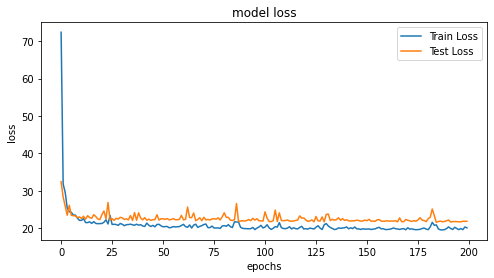

In [71]:
train_score = model.evaluate(trainX, trainY, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train MAPE : %.2f ' 
% (np.sqrt(train_score[1]), train_score[1]))
test_score = model.evaluate(testX, testY, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test MAPE : %.2f ' 
% (np.sqrt(test_score[1]), test_score[1]))
model_loss(model_history)

In [72]:
import seaborn as sns

In [73]:
def prediction_plot(testY, test_predict):
    len_prediction=[x for x in range(615,675)]
    plt.figure(figsize=(15,8))
    plt.plot(trainY)
    plt.plot(len_prediction, testY, marker='.', label="actual")
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Sales', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

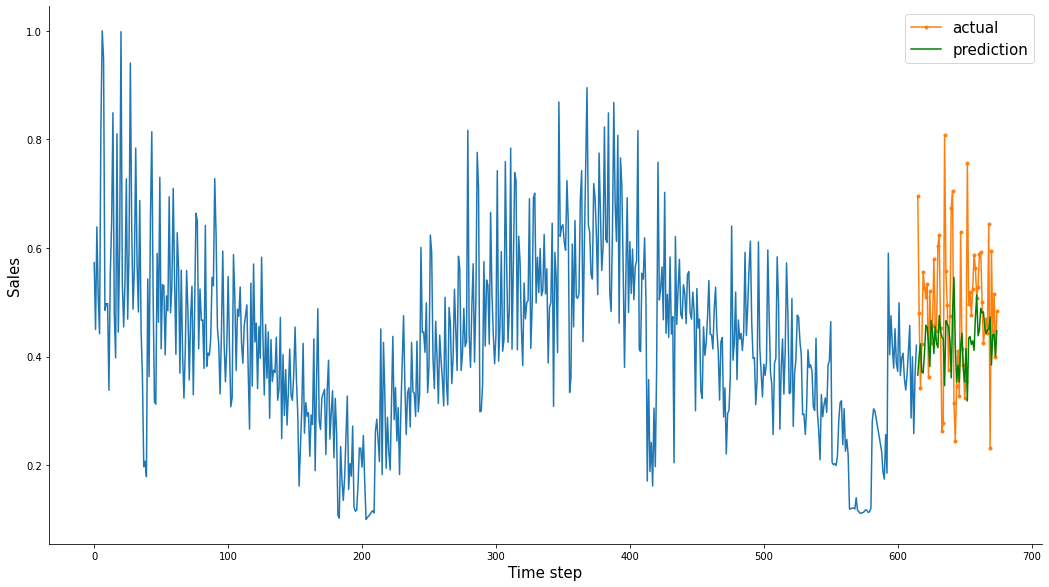

In [75]:
test_predict = model.predict(testX)
prediction_plot(testY, test_predict)